## Exploring the scaling of the number of orphan molecules

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from commons import *
import scipy.sparse as sp
import logging
from collections import Counter
from scipy import stats

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
mol_info = MoleculeInfo('/home/jupyter/data/PCL/LA_1600_1_molecule_info.h5', None)

In [3]:
# select mappable molecules
mappable_molecule_indices = np.where(mol_info.gene_array != mol_info.unmappable_gene_idx)[0]

# select barcodes within a certain total mappable UMI range
min_umi_count = 400
max_umi_count = np.inf
selected_molecule_indices = np.asarray([
    idx for idx in mappable_molecule_indices
    if min_umi_count <= mol_info.total_umi_per_barcode[mol_info.barcode_array[idx]] <= max_umi_count])

selected_gene_array = mol_info.gene_array[selected_molecule_indices]
selected_read_array = mol_info.reads_array[selected_molecule_indices]
selected_barcode_array = mol_info.barcode_array[selected_molecule_indices]

In [4]:
# gene indices sorted by expression in selected molecules
sorted_genes_by_expr = list(map(
    operator.itemgetter(0),
    sorted(list(Counter(selected_gene_array).items()),
           key=operator.itemgetter(1),
           reverse=True)))

## A heuristic method for estimating the real and chimeric expression per gene

In [24]:
max_genes = 1000
min_mu = 4.0
mu_list = []
e_chim_real_ratio_list = []

for gene_rank in range(max_genes):
    
    gene_index = sorted_genes_by_expr[gene_rank]
    reads = selected_read_array[selected_gene_array == gene_index]
    mu_putative = np.mean(reads[reads > 1])
    
    # if family size distribution is too compact, it the heuristic is unrealiable; skip
    if mu_putative <= min_mu:
        continue
    
    # estimate transition family size from chimeric to real
    max_trans = max(3, int(np.round(0.5 * int(mu_putative))) + 1)
    e_chim_putative = []
    for trans in range(2, max_trans):
        e_chim_putative.append(np.sum(reads < trans) - (trans - 1) * np.sum(reads == trans))
    trans = np.argmax(e_chim_putative) + 2

    # expression of chimeric
    e_chim = np.max(e_chim_putative)
    
    # expression of real
    e_real = np.sum(reads >= 1) - e_chim
    
    # ratio
    e_chim_real_ratio = e_chim / e_real
    
    # estimate average family size of real molecules
    real_reads = reads[reads > trans]
    num_reads_below_trans = trans * np.sum(reads == trans)
    num_reads_above_trans = np.sum(reads > trans)
    mu_real_below_trans = 0.5 * (trans + 1)
    mu_real_above_trans = np.mean(real_reads)
    mu = (mu_real_below_trans * num_reads_below_trans
          + mu_real_above_trans * num_reads_above_trans) / (num_reads_below_trans + num_reads_above_trans)

    mu_list.append(mu)
    e_chim_real_ratio_list.append(e_chim_real_ratio)

Text(0, 0.5, 'Ratio of chimeric to real')

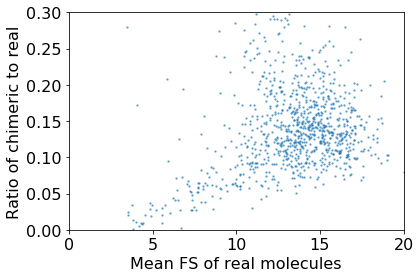

In [25]:
ax = plt.gca()
ax.scatter(mu_list, e_chim_real_ratio_list, s=2, alpha=0.5)
ax.set_ylim((0, 0.3))
ax.set_xlim((0, 20))
ax.set_xlabel('Mean FS of real molecules', fontsize=16)
ax.set_ylabel('Ratio of chimeric to real', fontsize=16)

## Mean family size vs. total reads (per cell)

In [ ]:
gene_index = sorted_genes_by_expr[29]
print('gene index:', gene_index)
print('gene name:', mol_info.gene_names_array[gene_index].decode('ascii'))

reads = selected_read_array[selected_gene_array == gene_index]

ax = plt.gca()
_ = ax.hist(reads, range=(0, 40), bins=40, density=True)
ax.set_xlabel('Family Size', fontsize=16)
ax.set_ylabel('Fraction of molecules', fontsize=16)

selected_mols = selected_gene_array == gene_index
mol_barcodes = selected_barcode_array[selected_mols]
mol_reads = selected_read_array[selected_mols]

Text(0, 0.5, 'Mean family size')

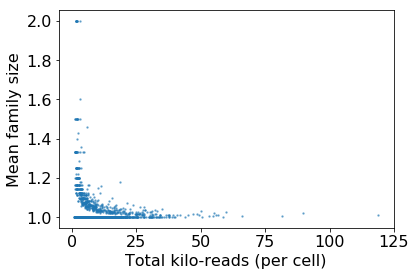

In [26]:
# any relation between mean family size and total reads per cell?
group_iter = itertools.groupby(zip(mol_barcodes, mol_reads), operator.itemgetter(0))
total_reads_per_cell = []
mean_family_size_per_cell = []
for barcode, grouper in group_iter:
    c_reads = [elem[1] for elem in grouper]
    total_reads_per_cell.append(mol_info.total_reads_per_barcode[barcode])
    mean_family_size_per_cell.append(np.mean(c_reads))

ax = plt.gca()
ax.scatter(np.asarray(total_reads_per_cell) / 1000, mean_family_size_per_cell, s=2, alpha=0.5)
ax.set_xlabel('Total kilo-reads (per cell)', fontsize=16)
ax.set_ylabel('Mean family size', fontsize=16)

## The Fano factor of chimeric vs. real molecules

In [27]:
def get_fano(l):
    return (np.std(l) ** 2) / np.mean(l)

In [28]:
# expression of a gene from just orphan molecules across all cells
orphan_read = 1
total_cells = len(np.unique(selected_barcode_array))
expressing_cells = len(np.unique(mol_barcodes))
group_iter = itertools.groupby(zip(mol_barcodes, mol_reads), operator.itemgetter(0))

# start with 0 for non-expressing cells
orphan_expr = [0] * (total_cells - expressing_cells)
for barcode, grouper in group_iter:
    orphan_expr.append(sum(1 for elem in grouper if elem[1] == orphan_read))

# a random sample from expression with the same number of molecules of the same gene from non-orphan molecules
total_orphans = np.sum(orphan_expr)
non_orphan_barcodes = mol_barcodes[mol_reads > orphan_read]
np.random.shuffle(non_orphan_barcodes)
random_non_orphan_barcodes = non_orphan_barcodes[:total_orphans]
random_non_orphan_expr_sample = list(Counter(random_non_orphan_barcodes).values())
random_non_orphan_expr_sample += [0] * (len(orphan_expr) - len(random_non_orphan_expr_sample))

orphan_fano = get_fano(orphan_expr)
non_orphan_fano = get_fano(random_non_orphan_expr_sample)

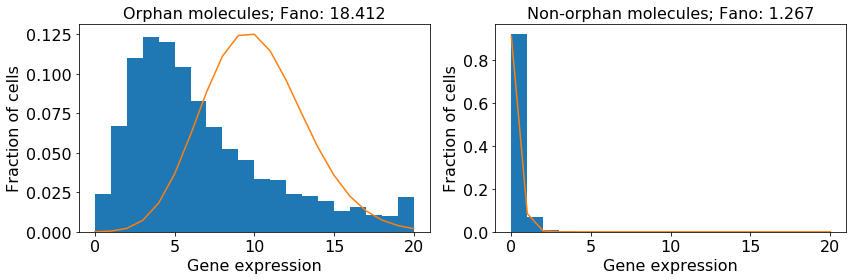

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

mu = np.mean(orphan_expr)
k = np.linspace(0, 20, num=21)
y = stats.poisson.pmf(mu=mu, k=k)
_ = axs[0].hist(orphan_expr, bins=20, range=(0, 20), density=True)
axs[0].plot(k, y)
axs[0].set_title(f'Orphan molecules; Fano: {orphan_fano:.3f}', fontsize=16)
axs[0].set_xlabel('Gene expression', fontsize=16)
axs[0].set_ylabel('Fraction of cells', fontsize=16)

mu = np.mean(random_non_orphan_expr_sample)
k = np.linspace(0, 20, num=21)
y = stats.poisson.pmf(mu=mu, k=k)
_ = axs[1].hist(random_non_orphan_expr_sample, bins=20, range=(0, 20), density=True)
axs[1].plot(k, y)
axs[1].set_title(f'Non-orphan molecules; Fano: {non_orphan_fano:.3f}', fontsize=16)
axs[1].set_xlabel('Gene expression', fontsize=16)
axs[1].set_ylabel('Fraction of cells', fontsize=16)

plt.tight_layout()

Text(0, 0.5, 'CDF')

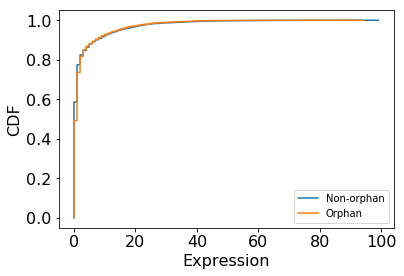

In [23]:
ax = plt.gca()
ax.plot(np.sort(random_non_orphan_expr_sample),
        np.linspace(0, 1, len(random_non_orphan_expr_sample), endpoint=False),
        label='Non-orphan')
ax.plot(np.sort(orphan_expr),
        np.linspace(0, 1, len(orphan_expr), endpoint=False),
        label='Orphan')
ax.legend()
ax.set_xlabel('Expression', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)